In this notebook, we're going to code a CNN. A convolutional neural network to classify handwritten digits. In another project, we coded up a feedforward neural network to classify handwritten digits.There, we flattened the image out all of the pixels. So we had 28 by 28 pixels flattened out, and each pixel was a feature. And then we had some hidden layers. We built a neural network with three hidden layers to classify this handwritten digit.

This is the CNN that we are going to built
![cnn_architecture](image_classification_architecture.png)

#### Here's a concise explanation for each step:

- **Input:** The network takes as input grayscale images of handwritten digits (0-9) from the MNIST dataset.

- **First Convolutional Layer:** This initial layer consists of eight filters that scan the input image to detect simple patterns, like edges and corners.

- **Max Pooling:** After the first convolution, max-pooling is applied to reduce the dimensions of the feature maps while retaining essential information.

- **Second Convolutional Layer:** A more complex layer with 32 filters is employed to capture higher-level features, like shapes and textures.

- **Max Pooling:** Similar to the first pooling layer, this reduces dimensions further and keeps critical features.

- **First Fully Connected Layer:** This layer flattens the max-pooled feature maps and connects them to 600 neurons, allowing for more advanced feature extraction.

- **Second Fully Connected Layer (Classification):** The final layer consists of 10 neurons, each corresponding to a digit (0-9). It classifies the input image into one of these ten categories, completing the digit recognition process.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
# defining parameters for data normalization (mean & SD), these are pre-calculated for MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

# input[channel] = (input[channel]-mean[channel]) / std[channel] <== formula of data normalization
transforms_original = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray))])
                                
# later we'll define another transformation "transforms_photo" to detech our handwritten image.
    
train_dataset = datasets.MNIST(root='./',
                              train=True,
                              transform=transforms_original,
                              download=True)
                                

test_dataset = datasets.MNIST(root='./',
                              train=False,
                              transform=transforms_original,
                              download=True)

***transforms.Compose()*** is a utility function provided by PyTorch that allows us to create a sequence of image transformations to be applied to our data in a specific order. It takes a list of individual transformations as input and returns a single composed transformation. Here, we've defined a list of individual transformation functions: ***transforms.ToTensor()*** and ***transforms.Normalize()***, where, ***transforms.ToTensor()*** converts the image data, which is originally in the form of pixels, into PyTorch tensors. ***transforms.Normalize((mean_gray,), (stddev_gray))*** normalizes the tensor values of the image.  Data normalization makes sure that the data has a mean of zero and a standard deviation of one, which can help with training stability and convergence. 

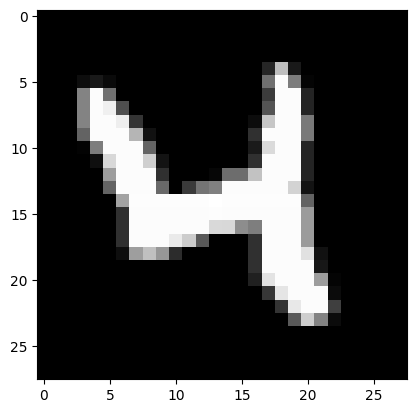

4


In [3]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray  

plt.imshow(random_img.reshape(28,28), cmap = 'gray')
plt.show()
plt.close()

# to print image label
print(train_dataset[20][1])

Each image has 2 input, first one is the image itself and the 2nd one is the label of the image, that is, the number that is written in the image. Here, we want to look at the 2oth image (index 0) but not it's label. We used **.numpy()** to convert the image to an array to plot and since each image is already normalized before, so to visualize it we need to denormalize the image again.

To see the image we have to reshape it correctly, that is, to its original shape and since all MNIST images are in grayscale so we use 'gray' colormap

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

That line is simply **resetting Matplotlib’s styling and configuration back to its factory defaults**. Here’s what’s happening:

* **`plt.rcParams`** is a dictionary-like object that holds all of Matplotlib’s runtime settings (fonts, line widths, color cycles, figure sizes, etc.).
* **`plt.rcParamsDefault`** is another dict that contains the original default values for all of those settings.
* **`.update(plt.rcParamsDefault)`** replaces whatever you might have changed in `rcParams` with the defaults from `rcParamsDefault`.

In [4]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                        batch_size = batch_size,
                                        shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False)


In [5]:
len(train_load)   # 6000 / 100 ==> 600

600

In [6]:
class CNN(nn.Module):
    def __init__(self):
        # While it's possible to specify all the parameters as input of init function, 
        # but here I'll directly hardcode all parameters inside the function
        super(CNN, self).__init__()
        
        # first Conv layer
        # same padding --> input_size = output_size
        # same padding = (filter_size - 1)/2 --> (3-1)/2 = 1
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)   # 1st Conv layer
        # since same padding is used,so output size is also 28*28 (calculation shown below)
        self.batchnorm1 = nn.BatchNorm2d(8) # since there are 8 feature maps
        self.relu = nn.ReLU()
        
        # MaxPool for Conv1
        # in this cnn, maxpooling is applied 2 times but both times same kernel size is used.
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        # the output size = 28/2 = 14
        
        # second Conv layer
        # same padding --> input_size = output_size
        # same padding = (filter_size - 1)/2 --> (5-1)/2 = 2
        self.cnn2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        # output size of each of the 32 feature maps [(14 - 5 + 2*2)/1 + 1] = 14
        self.batchnorm2 = nn.BatchNorm2d(32) # since there are 8 feature maps
        
        # MaxPool for Conv2
        # maxpooling already specified once, since same kernel_size is used so we don't need to specify it agian
        # # the output size after maxpooling again = 14/2 = 7
        
        # fully connected 2 layers
        # flaten the 32 feature maps: 7*7*32 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600) # input_neurons(calculated), output_neurons(choosen)
        # we'll use the same ReLU activation function
        self.dropout = nn.Dropout(p = 0.5)   # Explanation given below
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        # so DONE with initialization functions
        
    # Let's define forward function
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568) # flattening the 32 feature maps to feed it to the FC1 (100, 1568)
        
        # Then we forward through our fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out
        

conv2d is the class from the model which is responsible for constructing a convolutional layer.

For the first convolutional layer:

- Number of input channels: look at the previous layer, we see that there is a grayscale image, so the number of input channel is 1.
- Number of output channels (filters): 8 (each filter will produce a feature map)
- Filter size (kernel size): 3x3.
- Stride: 1 (to avoid downsampling).
- Padding: 1.
- the output size of each of the 8 feature maps:

$$
\frac{\text{input\_size} - \text{filter\_size} + 2 \times (\text{padding})}{\text{stride}} + 1
\;=\;
\frac{28 - 3 + 2 \times 1}{1} + 1
\;=\;
28
$$




It's a best practice to include a Dropout layer between fully connected layers to enhance regularization. We didn't do this previously but from now on we'll continue adding it. In this case, a Dropout layer with a probability of P=0.5 is added between the fully connected layers.

## What’s Happening in This CNN Class

This `CNN` model is a small convolutional neural network for classifying 28×28 grayscale images (like MNIST digits). Here’s a step-by-step, easy-to-follow breakdown:

1. **Initialization (`__init__`)**  
   - **Conv1**: A 3×3 convolution that turns the single input channel into 8 feature maps.  
     - We use **padding=1** so the output remains 28×28.  
   - **BatchNorm1 + ReLU**: Normalizes each of the 8 feature maps, then applies a ReLU nonlinearity.  
   - **MaxPool**: Halves the spatial size (28→14) by taking the maximum over each 2×2 block.  
   - **Conv2**: A 5×5 convolution expanding from 8 to 32 feature maps, with **padding=2** to keep the size at 14×14.  
   - **BatchNorm2 + ReLU**: Normalizes the 32 maps, then adds nonlinearity.  
   - **MaxPool**: Again halves spatial size (14→7).  
   - **Flatten**: Turns the 7×7×32 tensor into a single 1D vector of length 7×7×32 = 1568.  
   - **FC1 (600 units)**: A fully connected layer learns from these 1568 features.  
   - **Dropout (p=0.5)**: Randomly “drops” half the neurons during training to prevent overfitting.  
   - **FC2 (10 units)**: The final layer maps to 10 outputs—one score for each digit class (0–9).

2. **Forward Pass (`forward`)**  
   - The input image goes through Conv1 → BatchNorm → ReLU → MaxPool.  
   - Then through Conv2 → BatchNorm → ReLU → MaxPool again.  
   - We **flatten** the pooled feature maps, run them through FC1 + ReLU + Dropout, and finally through FC2.  
   - The raw outputs (logits) from FC2 can then be fed into a softmax or cross-entropy loss for training.

### Why This Structure?
- **Convolutions** learn to detect simple patterns (edges, corners) then more complex ones (shapes, textures).  
- **Pooling** reduces image size, making the network faster and more robust to small shifts.  
- **BatchNorm** and **Dropout** help stabilize and regularize training.  
- **Fully connected layers** combine all the learned features to make the final digit prediction.


In [7]:
# defining the model
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    # moving the model to gpu
    model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [8]:
# understand what is happening
iteration = 0
correct = 0
for i, (inputs, labels) in enumerate(train_load):
    # for each i we are getting 1 full batch.
    
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iteration, this is what happens:")
    # Each tensor propagated through the network should be 4D (batch_size, channels, rows, cols)
    print("Input Shape:", inputs.shape)
    print("Labels shape:",labels.shape)
    output = model(inputs)
    print("outputs Shape", output.shape)
    _, predicted = torch.max(output, 1)  # maximum across the class dimension
    print("Predicted Shape:", predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    break

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])
outputs Shape torch.Size([100, 10])
Predicted Shape: torch.Size([100])
Predicted Tensor:
tensor([8, 2, 8, 2, 8, 2, 2, 8, 8, 2, 2, 2, 2, 8, 2, 6, 8, 8, 8, 8, 2, 8, 8, 6,
        2, 2, 8, 8, 2, 8, 2, 2, 4, 2, 2, 8, 8, 8, 8, 8, 8, 2, 4, 2, 8, 2, 6, 8,
        8, 2, 3, 8, 6, 8, 2, 2, 8, 8, 2, 8, 8, 2, 9, 9, 8, 2, 2, 2, 6, 8, 8, 9,
        8, 8, 2, 8, 8, 8, 6, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 6, 6,
        2, 2, 6, 8], device='cuda:0')


In [10]:
# Training the cnn
num_epochs = 10

# Define the lists to store the results of Loss and Acurracy
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

# Training
for epoch in range(num_epochs):
    # Reset these below variables to 0 athe the beginning of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0  # loss for 1 iteration
    
    model.train()        # put the network in training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        if CUDA: 
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        #forward prop
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item() #since loss is a tensor, to extract the value item, .item() method is used
        
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Record the correct predictions for training data and calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    train_loss.append(iter_loss/iterations) #average training loss
    train_accuracy.append((100 * correct / len(train_dataset)))   
  
    
    # testing phase
    # for each epoch these values will reset to zero for testing phase
    testing_loss = 0.0
    correct = 0
    iterations = 0
    
    
    model.eval()  # this tells pytorch that we're in testing phase
    
    for i, (inputs, labels) in enumerate(test_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        testing_loss += loss.item()
        
        
        _, predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    test_loss.append(testing_loss/iterations) #average training loss
    test_accuracy.append((100 * correct / len(test_dataset)).cpu().numpy())
    
    print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}"
          .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))       

Epoch 1/10, Training Loss: 0.464, Training Accuracy: 87.857, Testing Loss: 0.141, Testing Accuracy: 96.200
Epoch 2/10, Training Loss: 0.149, Training Accuracy: 95.740, Testing Loss: 0.095, Testing Accuracy: 97.160
Epoch 3/10, Training Loss: 0.108, Training Accuracy: 96.908, Testing Loss: 0.071, Testing Accuracy: 97.820
Epoch 4/10, Training Loss: 0.088, Training Accuracy: 97.457, Testing Loss: 0.062, Testing Accuracy: 98.080
Epoch 5/10, Training Loss: 0.075, Training Accuracy: 97.813, Testing Loss: 0.054, Testing Accuracy: 98.310
Epoch 6/10, Training Loss: 0.068, Training Accuracy: 98.002, Testing Loss: 0.048, Testing Accuracy: 98.490
Epoch 7/10, Training Loss: 0.062, Training Accuracy: 98.158, Testing Loss: 0.046, Testing Accuracy: 98.550
Epoch 8/10, Training Loss: 0.057, Training Accuracy: 98.330, Testing Loss: 0.042, Testing Accuracy: 98.610
Epoch 9/10, Training Loss: 0.052, Training Accuracy: 98.443, Testing Loss: 0.042, Testing Accuracy: 98.580
Epoch 10/10, Training Loss: 0.050, Tr

since dropout and batchnorm behave differently in training and testing time so we need to define the mode whether it's training or testing time

In [ ]:
# plotting the loss
f = plt.figure(figsize = (10,10))
plt.plot(train_loss, label = "Training Loss")
plt.plot(test_loss, label = "Testing Loss")
plt.legend()
plt.show()
plt.close(f)

In [11]:
print('Test Loss: {}\n'.format(test_loss[:3]))
print('Train Loss: {}\n'.format(train_loss[:3]))
print('Test Accuracy: {}\n'.format(test_accuracy[:3]))
print('Train Accuracy: {}\n'.format(train_accuracy[:3]))

Test Loss: [0.14061046832241117, 0.09530659989919514, 0.07135234406217933]

Train Loss: [0.46378615193068984, 0.14903729490935802, 0.1075982066988945]

Test Accuracy: [array(96.2, dtype=float32), array(97.159996, dtype=float32), array(97.82, dtype=float32)]

Train Accuracy: [tensor(87.8567, device='cuda:0'), tensor(95.7400, device='cuda:0'), tensor(96.9083, device='cuda:0')]



To extract only the numbers from test_accuracy (lists of numpy array) and train_accuracy (lists of pytorch tensors) ***.item()*** method is used.

In [ ]:
# Assuming train_accuracy is a list of PyTorch tensors on the GPU
# Convert the GPU tensors to CPU and extract their values as NumPy arrays
#train_accuracy_cpu = [acc.cpu().detach().numpy() for acc in train_accuracy]
train_accuracy = [acc.item() for acc in train_accuracy]
test_accuracy = [acc.item() for acc in test_accuracy]

# plotting the accuracy
f = plt.figure(figsize = (10,10))
plt.plot(train_accuracy, label = "Training Accuracy")
plt.plot(test_accuracy, label = "Testing Accuracy")
plt.legend()
plt.show()
plt.close(f)

Now, after we've trained and tested our model, what we want to do is take any test image and see what's the prediction.

Let's load an image from the testing dataset, specifically image number 30, and prepare it for the model's forward propagation. Each image in the dataset has two indices, with the first one (index 0) corresponding to the image itself. To make it compatible for the model, we'll resize the image to a four-dimensional tensor with a batch size of 1 (since we're testing one image), one channel, and dimensions of 28x28. This format is required for PyTorch's forward propagation.

In [12]:
img = test_dataset[30][0].resize_((1,1,28,28)) #taking a random image from the dataset
label = test_dataset[30][1] #taking the label of the img

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()
    
outputs = model(img)
_, predicted = torch.max(outputs,1)
print("Prediction is : {}".format(predicted.item()))
print("Actual is : {}".format(label))

Prediction is : 3
Actual is : 3


### Classifying own handwritten images

In [13]:
# at first we need to import 2 extra libraries to process image
import cv2
from PIL import Image

now we need to make some transformation as we did earlier while loading training and testing images. Resizing, converting to tensor, normalizing and makeing it a grayscale image(will do it by cv2, but we could do it by transorms.grayscale)

In [14]:
transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((mean_gray,),(stddev_gray))])

In [28]:
def predict(img_name,model):
    image = cv2.imread(img_name,0) # read the image and 0 means to transform it to grayscale image
    
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY) #explanation given below
    img = 255-thresholded # explanation given below
    
    cv2.imshow('Thresholded',thresholded)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    cv2.imshow('Original',img)    # to display the image
    cv2.waitKey(0)             # explanation given below
    cv2.destroyAllWindows()       # explanation given below
    img = Image.fromarray(img)    # explanation given below
    img = transforms_photo(img)   # explanation given below
    img = img.view(1,1,28,28)     # resize the image to the expected size(batch_size,channels,height,width) by our cnn.
    #img = Variable(img)           # wrapping the image to a variable
    
    model.eval()
    
    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()
        
    output = model(img)
    print(output)
    print(output.data)
    _,predicted = torch.max(output,1)
    return predicted.item()

In [29]:
pred = predict('5.jpeg',model)
print("The predicted label is {}".format(pred))

tensor([[-1.2950, -4.4155,  1.3594,  3.3704, -5.2449,  9.5330, -3.6802, -1.6542,
          1.6370,  3.3882]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.2950, -4.4155,  1.3594,  3.3704, -5.2449,  9.5330, -3.6802, -1.6542,
          1.6370,  3.3882]], device='cuda:0')
The predicted label is 5


At first we'll make our image completely white background and black digit(foreground) so that there are no other color present in the image but since our model is trained with image of black background and white digit so we'll convert the image to such type of image.

### 1. Thresholding:

   - Thresholding is a technique used in image processing to create a binary image, which means that each pixel in the resulting image can be one of two values, typically 0 (black) or 255 (white). It's a way to segment an image into regions or objects based on pixel intensity.

### 2. cv2.threshold Function:

   - The **cv2.threshold** function in the OpenCV library is used to perform thresholding.
   - It takes several arguments:
        - **image**: The input image you want to threshold.
        - **127**: The threshold value. This value is used to separate pixels into two groups: those below the threshold and those equal to or above the threshold.
        - **255**: The maximum value assigned to pixels that pass the threshold. In this case, pixels with values greater than or equal to 127 become 255 (white).
        - **cv2.THRESH_BINARY**: The type of thresholding. This option specifies that if a pixel value is greater than or equal to the threshold (127), it becomes the maximum value (255); otherwise, it becomes the minimum value (0, which is black).

### 3. Output of Thresholding:

   - After thresholding, you obtain a new image called thresholded, where pixels in regions of interest are set to 255 (white), and background pixels are set to 0 (black).
   - Pixels below the threshold (less than 127) are set to 0, and pixels equal to or above the threshold (greater than or equal to 127) are set to 255.

### 4. Creating the Image Negative:

   - To invert the colors of the binary image, the code calculates the image negative.
   - It subtracts the thresholded image from 255, effectively turning the black regions (background) to white and the white regions (digits or objects of interest) to black.

### Example:
Suppose you have a grayscale image represented as a 2D array like this:
\begin{bmatrix}
  100 & 150 & 200 \\
  50 & 120 & 80 \\
  170 & 210 & 90 \\
\end{bmatrix}
Using the **cv2.threshold** function with a threshold of 127 and **cv2.THRESH_BINARY**, the result would be:
\begin{bmatrix}
  255 & 255 & 255 \\
  0 & 255 & 0 \\
  255 & 255 & 0 \\
\end{bmatrix}
In the resulting binary image, values above the threshold (127) become 255 (white), and values below the threshold become 0 (black).

Then, to create the image negative, you would subtract this image from 255, resulting in:
\begin{bmatrix}
  0 & 0 & 0 \\
  255 & 0 & 255 \\
  0 & 0 & 255 \\
\end{bmatrix}

**cv2.waitkey(0)**: pauses the program's execution, waiting for user input, and it will wait indefinitely until a key is pressed by the user.

**cv2.destroyAllwindows()**: This function is used to close all open OpenCV windows, ensuring that any displayed windows are properly closed before the program exits.

**img = Image.fromarray(img)** this line converts the image from a NumPy array (representing pixel values) into a PIL (Python Imaging Library) image (as this is the required image format for PyTorch)
to pass it through the transformation: **transforms_photo(img)** because later we'll provide it to PyTorch model.